# calculate stock returns

In [1]:
import wrds
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os
from pathlib import Path

FIG_DIR = Path("docs/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_colwidth', 100) 
pd.set_option('display.width', 1000)  


load_dotenv()
username = os.getenv("WRDS_USERNAME")

#dates for pulling data from database (date overlaps as historical data are needed to construct some features)
periods = {
    'train' : ('1997-12-20', '2011-01-01'),
    'valid' : ('2008-12-20', '2016-01-01'),
    'test'  : ('2013-12-20','2024-01-01'),
    'github'  : ('2013-12-20','2018-08-28'),
    'trainval'  : ('1997-12-20','2016-01-01')
}

# choose which period to run
period = 'test'
data_start_date = periods[period][0]
data_end_date = periods[period][1]

conn = wrds.Connection(wrds_username=username)

#Compustat
query = f"""
SELECT conm, cusip, tic, tpci, datadate, exchg, prccd, ajexdi

FROM  comp_na_daily_all.secd

WHERE 
    datadate BETWEEN '{data_start_date}' AND '{data_end_date}'
    AND tpci IN ('0') -- Limiting the search to stocks only
    AND exchg IN (11) -- Limiting the search to NYSE (11) or/and NASDAQ (14)
    AND iid = '01' --Some companies have multiple classes of stocks. Here taking only class A
"""

df_price = conn.raw_sql(query, params=None)
conn.close()
df_price['cusip'] = df_price['cusip'].str[:-1]

df_price['adjusted_price'] = df_price['prccd'] / df_price['ajexdi']
df_price['datadate'] = pd.to_datetime(df_price['datadate'])
df_price

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,conm,cusip,tic,tpci,datadate,exchg,prccd,ajexdi,adjusted_price
0,AAR CORP,00036110,AIR,0,2013-12-20,11,29.22,1.0,29.22
1,ALEXANDER'S INC,01475210,ALX,0,2013-12-20,11,334.73,1.0,334.73
2,ALEXANDER'S INC,01475210,ALX,0,2013-12-23,11,339.87,1.0,339.87
3,ALEXANDER'S INC,01475210,ALX,0,2013-12-24,11,343.36,1.0,343.36
4,ALEXANDER'S INC,01475210,ALX,0,2013-12-26,11,344.92,1.0,344.92
...,...,...,...,...,...,...,...,...,...
38492,NVENT ELECTRIC PLC,G6700G10,NVT,0,2023-07-25,11,52.86,1.0,52.86
38493,NVENT ELECTRIC PLC,G6700G10,NVT,0,2023-07-26,11,52.23,1.0,52.23
38494,NVENT ELECTRIC PLC,G6700G10,NVT,0,2023-07-27,11,52.33,1.0,52.33
38495,NVENT ELECTRIC PLC,G6700G10,NVT,0,2023-07-28,11,53.21,1.0,53.21


In [60]:
from pathlib import Path

FIG_DIR = Path("docs/figures")
RES_DIR = Path("results")

FIG_DIR.mkdir(parents=True, exist_ok=True)
RES_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
# --- LightGBM (optional model) ---
import lightgbm as lgb

def fit_lightgbm_regressor(X_train, y_train, X_val=None, y_val=None, random_state=42):
    """Fit a LightGBM regressor for cross-sectional return prediction.
    Cleans inf/NaN, aligns indices, and uses early stopping if validation data is provided."""
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    y_train = y_train.replace([np.inf, -np.inf], np.nan)
    train_idx = X_train.dropna().index.intersection(y_train.dropna().index)
    X_train = X_train.loc[train_idx]
    y_train = y_train.loc[train_idx]

    dtrain = lgb.Dataset(X_train, label=y_train, free_raw_data=False)

    valid_sets = [dtrain]
    valid_names = ["train"]
    if X_val is not None and y_val is not None:
        X_val = X_val.replace([np.inf, -np.inf], np.nan)
        y_val = y_val.replace([np.inf, -np.inf], np.nan)
        val_idx = X_val.dropna().index.intersection(y_val.dropna().index)
        X_val = X_val.loc[val_idx]
        y_val = y_val.loc[val_idx]
        dval = lgb.Dataset(X_val, label=y_val, reference=dtrain, free_raw_data=False)
        valid_sets = [dtrain, dval]
        valid_names = ["train", "val"]

    params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": 0.05,
        "num_leaves": 31,
        "min_data_in_leaf": 50,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 1,
        "lambda_l2": 1.0,
        "verbosity": -1,
        "seed": random_state,
    }

    model = lgb.train(
        params,
        dtrain,
        num_boost_round=2000,
        valid_sets=valid_sets,
        valid_names=valid_names,
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)],
    )
    return model


In [3]:
adj_price_df = df_price[['cusip', 'datadate', 'adjusted_price']].copy().set_index(['datadate', 'cusip']).unstack()
#adj_price_df = adj_price_df.ffill()

return_df = adj_price_df/adj_price_df.shift(1)-1
return_df.columns = return_df.columns.get_level_values(1)
return_df.head()

cusip,00036110,00090Q10,00091G10,00095710,00101J10,00105510,00108410,00120410,00122850,00130H10,00152K20,00154710,00165C30,00174410,00181T10,00184X10,00187Y10,00191G10,00191U10,00206R10,00212110,00217Y10,00244410,00247410,00258W10,00282410,00287Y10,00289620,00423910,00434L10,00436Q10,00489Q10,00508Y10,00509810,00737L10,00751Y10,00766T10,00773T10,00776710,00778610,00780010,00782L10,00790R10,00790X10,00817Y10,00825210,00846U10,00847410,00849210,00857U10,...,M8737E10,M8893U10,M9607U11,M9T95110,N0098510,N1450610,N2094410,N3144W10,N3167Y10,N3346210,N4727910,N5374510,N7248220,N8240510,N9420912,P1666E10,P1699413,P3107610,T9224W10,V7780T10,Y0207T10,Y0436Q10,Y0553W10,Y1023010,Y1771G10,Y1968P12,Y2065G12,Y2066G10,Y2067610,Y2106R11,Y2188B10,Y2294C10,Y2687W10,Y2990R10,Y3262R10,Y4105310,Y4671710,Y4812510,Y6213210,Y6213410,Y6215914,Y6219711,Y6226740,Y6417710,Y7388L10,Y7542C13,Y8564M10,Y8565J10,Y8977Y10,Y9384M10
datadate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-12-20,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2013-12-23,-0.007871,<NA>,<NA>,0.008197,0.008062,0.010663,0.014405,-0.006372,0.011111,0.004888,<NA>,0.047486,0.003049,0.009662,<NA>,-0.006695,<NA>,0.021144,0.014637,0.01137,<NA>,0.0,0.002151,0.001228,<NA>,0.015856,-0.00019,0.012154,0.0,0.018825,<NA>,0.00491,0.008372,<NA>,-0.006313,0.004389,0.007568,<NA>,0.00161,<NA>,0.006169,<NA>,<NA>,<NA>,0.007316,0.01437,0.010183,0.009131,0.004917,<NA>,...,0.015674,<NA>,<NA>,<NA>,0.006815,<NA>,0.011009,<NA>,<NA>,-0.028215,-0.002681,-0.006616,0.000857,0.005734,<NA>,<NA>,0.002162,-0.002201,<NA>,0.001917,0.030791,0.010356,0.025974,<NA>,0.019058,0.010438,0.029734,0.007547,<NA>,<NA>,0.028965,0.034115,<NA>,<NA>,<NA>,<NA>,<NA>,0.018552,0.044018,<NA>,0.038005,0.058824,-0.020302,<NA>,0.033066,0.000842,0.01007,0.030293,<NA>,<NA>
2013-12-24,-0.007244,<NA>,<NA>,0.010251,0.003749,0.001959,0.003935,0.003634,0.002586,0.005559,<NA>,0.049333,-0.010638,-0.000684,<NA>,0.003595,<NA>,-0.035323,0.00577,0.007495,<NA>,0.0,0.007153,0.007562,<NA>,-0.006504,-0.004184,0.003603,0.0,0.006837,<NA>,-0.008143,0.011439,<NA>,0.011551,0.004006,0.004438,<NA>,0.012862,<NA>,-0.001672,<NA>,<NA>,<NA>,-0.001482,0.000561,-0.005388,0.045633,0.003495,<NA>,...,0.002984,<NA>,<NA>,<NA>,-0.003905,<NA>,0.0,<NA>,<NA>,0.01546,0.010305,0.01396,0.000856,-0.00131,<NA>,<NA>,0.021215,0.001072,<NA>,0.008289,0.001358,0.008021,-0.006329,<NA>,0.009901,0.002066,0.00304,0.00824,<NA>,<NA>,0.007845,0.036082,<NA>,<NA>,<NA>,<NA>,<NA>,-0.011071,0.022614,<NA>,-0.002288,-0.014368,0.000531,<NA>,-0.024248,0.000841,0.005459,-0.004643,<NA>,<NA>
2013-12-26,0.00417,<NA>,<NA>,-0.003149,0.019422,0.009477,0.005624,0.003834,-0.014829,-0.000691,<NA>,0.007624,0.012801,0.007524,<NA>,0.023953,<NA>,-0.001263,0.017212,0.006009,<NA>,0.0,-0.00071,0.00142,<NA>,0.00419,0.012032,0.004786,0.003567,0.010277,<NA>,-0.009852,0.003831,<NA>,0.003711,-0.000997,-0.00136,<NA>,-0.011111,<NA>,0.001117,<NA>,<NA>,<NA>,0.013953,0.003598,0.004019,-0.00301,0.002786,<NA>,...,0.010975,<NA>,<NA>,<NA>,0.004182,<NA>,0.005445,<NA>,<NA>,-0.013368,0.007095,0.002021,-0.00513,0.001852,<NA>,<NA>,0.001056,-0.001007,<NA>,-0.006324,0.039322,0.009284,0.047771,<NA>,-0.002179,0.008247,0.012121,0.013373,<NA>,<NA>,0.030678,-0.006965,<NA>,<NA>,<NA>,<NA>,<NA>,0.046948,-0.001124,<NA>,0.025229,0.108844,0.032926,<NA>,0.048708,-0.004202,0.002125,0.000622,<NA>,<NA>
2013-12-27,-0.008997,<NA>,<NA>,0.005967,0.005129,0.002086,-0.001695,0.002122,0.008508,-0.000692,<NA>,0.02396,0.0182,0.004752,<NA>,-0.012243,<NA>,0.007585,-

In [4]:
monthly_return = (return_df+1).rolling(21).apply(np.prod, raw=True) - 1
monthly_volatility = return_df.rolling(21).std()
monthly_sharpe = monthly_return/monthly_volatility
monthly_return

cusip,00036110,00090Q10,00091G10,00095710,00101J10,00105510,00108410,00120410,00122850,00130H10,00152K20,00154710,00165C30,00174410,00181T10,00184X10,00187Y10,00191G10,00191U10,00206R10,00212110,00217Y10,00244410,00247410,00258W10,00282410,00287Y10,00289620,00423910,00434L10,00436Q10,00489Q10,00508Y10,00509810,00737L10,00751Y10,00766T10,00773T10,00776710,00778610,00780010,00782L10,00790R10,00790X10,00817Y10,00825210,00846U10,00847410,00849210,00857U10,...,M8737E10,M8893U10,M9607U11,M9T95110,N0098510,N1450610,N2094410,N3144W10,N3167Y10,N3346210,N4727910,N5374510,N7248220,N8240510,N9420912,P1666E10,P1699413,P3107610,T9224W10,V7780T10,Y0207T10,Y0436Q10,Y0553W10,Y1023010,Y1771G10,Y1968P12,Y2065G12,Y2066G10,Y2067610,Y2106R11,Y2188B10,Y2294C10,Y2687W10,Y2990R10,Y3262R10,Y4105310,Y4671710,Y4812510,Y6213210,Y6213410,Y6215914,Y6219711,Y6226740,Y6417710,Y7388L10,Y7542C13,Y8564M10,Y8565J10,Y8977Y10,Y9384M10
datadate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-12-26,-0.073886,0.121870,-0.014753,0.105046,NaN,-0.014709,0.056724,NaN,0.2461

# Functions for calculating momentum features

In [5]:
zscore = lambda x: (x - x.mean())/x.std()

In [6]:
#DataFrame to Store Features and Target
#add target
target= monthly_return.shift(-21).stack(dropna=False).copy().to_frame()
target.columns = ['monthly_return']
#target=target.groupby(level=0).transform(zscore)
target

monthly_return
datadate   cusip                   
2013-12-20 00036110       -0.028747
           00090Q10             NaN
           00091G10             NaN
           00095710        0.001069
           00101J10       -0.016881
...                             ...
2023-12-29 Y7542C13             NaN
           Y8564M10             NaN
           Y8565J10             NaN
           Y8977Y10             NaN
           Y9384M10             NaN

[5694080 rows x 1 columns]

In [7]:
def RSI(return_df, n):
    '''
    data frame of returns (col: stock, row: dates)
    n: number of days to look back 

    returns PIT RSI observed in the previous n_days
    
    '''
    #Keep magnitude of gain (up) or losses (down) for calculating avg
    up=return_df.map(lambda x : x if x>0 else 0, na_action= 'ignore')
    down=return_df.map(lambda x : -x if x<0 else 0, na_action= 'ignore')

    avg_up=up.shift(1).rolling(n).mean()
    avg_down=down.shift(1).rolling(n).mean()
    
    n_day_rsi = 100 - (100/ (1+ avg_up/avg_down))
    return n_day_rsi

In [8]:
def TSI(price, smooth_1 = 25, smooth_2 = 13):
    '''
    Double Smoothed PC
    ------------------
    PC = Current Price minus Prior Price
    First Smoothing = 25-period EMA of PC
    Second Smoothing = 13-period EMA of 25-period EMA of PC
    
    Double Smoothed Absolute PC
    ---------------------------
    Absolute Price Change |PC| = Absolute Value of Current Price minus Prior Price
    First Smoothing = 25-period EMA of |PC|
    Second Smoothing = 13-period EMA of 25-period EMA of |PC|
    
    TSI = 100 x (Double Smoothed PC / Double Smoothed Absolute PC)
    data frame of price (col: stock, row: dates)
    smooth_1:
    smooth_2: 

    returns PIT RSI observed in the previous n_days
    '''
    pc= price-price.shift(1)
    apc= abs(pc)
    #double smooth pc
    ema_pc = pc.ewm(span=smooth_1, axis=0, adjust=False).mean()
    ema_ema_pc = ema_pc.ewm(span=smooth_2, axis=0, adjust=False).mean()

    #double smooth apc
    ema_apc = apc.ewm(span=smooth_1, axis=0, adjust=False).mean()
    ema_ema_apc = ema_apc.ewm(span=smooth_2, axis=0, adjust=False).mean()
    #calculate tsi
    tsi = ema_ema_pc/ema_ema_apc * 100

    pit_tsi= tsi.shift(1)

    #only return days with sufficient smoothing
    return pit_tsi.iloc[smooth_1:, :]

In [9]:
def rolling_momentum(dataframe, months=12, exclude_last_month=True, 
                     smoothing_type='sma', smoothing_window=3, 
                     weight_recent=True):

    """
    Calculates the rolling momentum with optional smoothing and recent-weighting adjustments.

    Args:
    - dataframe (pd.DataFrame): DataFrame with daily price data, columns as stock tickers, rows as dates.
    - months (int): Number of months to calculate momentum over (default is 12).
    - exclude_last_month (bool): Whether to exclude the most recent month in calculation (default is True).
    - smoothing_type (str): Type of smoothing to apply; 'sma' (simple moving average) or 'ewma' (exponentially weighted moving average).
    - smoothing_window (int): Window size for smoothing in SMA (default is 3).
    - weight_recent (bool): If True, applies recent weighting using EWMA with specified span.
    - ewm_span (int): The span parameter for EWMA, controlling the decay rate (default is 3).

    Returns:
    - momentum_df (pd.DataFrame): DataFrame containing the rolling momentum for each stock.
    """

    dataframe = dataframe.copy()
    dataframe.index = pd.to_datetime(dataframe.index)

    # Calculate momentum over the specified period
    if exclude_last_month:
        shifted_df = dataframe.shift(21)  # assuming 21 trading days per month
        momentum_df = (shifted_df - dataframe.shift(252)) / dataframe.shift(252)
    else:
        momentum_df = (dataframe - dataframe.shift(252)) / dataframe.shift(252)

    # Apply smoothing based on the chosen method
    if smoothing_type == 'sma':
        smoothed_momentum = momentum_df.rolling(window=smoothing_window, min_periods=1).mean()
    elif smoothing_type == 'ewma':
        smoothed_momentum = momentum_df.ewm(span=smoothing_window, adjust=False).mean()
    else:
        smoothed_momentum = momentum_df

    return smoothed_momentum

In [10]:
def generate_momentum_features(dataframe, sma_windows=[3, 5, 10, 50, 100], ema_windows=[3, 5, 10, 50, 100], months=12):
    """
    Generates momentum features for specified SMA and EMA windows.
    
    Args:
    - dataframe (pd.DataFrame): DataFrame with daily price data, columns as stock tickers, rows as dates.
    - sma_windows (list): List of windows for SMA-based momentum features.
    - ema_windows (list): List of windows for EMA-based momentum features.
    - months (int): Number of months to calculate momentum over (default is 12).

    Returns:
    - features_df (pd.DataFrame): DataFrame with momentum features and monthly returns.
    """
    # Copy and setup
    adj_price_df = dataframe.copy()
    adj_price_df.index = pd.to_datetime(adj_price_df.index)
    momentum_features = {}

    # Generate SMA features
    for sma_window in sma_windows:
        col_name = f"Momentum_SMA_{sma_window}"
        # Stack to align (date, ticker) structure
        momentum_features[col_name] = rolling_momentum(adj_price_df, smoothing_type='sma', smoothing_window=sma_window).stack()
        #print(f"{col_name} shape:", momentum_features[col_name].shape)

    # Generate EMA features
    for ema_window in ema_windows:
        col_name = f"Momentum_EMA_{ema_window}"
        # Stack to align (date, ticker) structure
        momentum_features[col_name] = rolling_momentum(adj_price_df, smoothing_type='ewma', smoothing_window=ema_window).stack()
        #print(f"{col_name} shape:", momentum_features[col_name].shape)

    # Combine features into a single DataFrame (columns become feature names, index is date and ticker)
    features_df = pd.concat(momentum_features, axis=1)
    features_df.columns = list(momentum_features.keys())
    
    #PIT
    features_df = features_df.shift(1)
    return features_df

In [11]:
rsi = RSI(return_df, 15)
rsi = rsi.transform(zscore , axis=1)
rsi = rsi.stack().to_frame()
rsi.columns = ['rsi']

In [12]:
tsi = TSI(return_df, 15)
tsi = tsi.transform(zscore , axis=1)
tsi = tsi.stack().to_frame()
tsi.columns = ['tsi']

In [13]:
momentum = generate_momentum_features(adj_price_df, sma_windows=[], ema_windows=[3, 10])
#get zscore
momentum = momentum.groupby('cusip').transform(lambda x: x.pct_change())
momentum = momentum.groupby(level=0).transform(zscore)

/Users/michaeljankowski/Quant/Projects/optim-project/venv/lib/python3.12/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [14]:
price_features = pd.concat([target, rsi], axis=1).dropna()
price_features = price_features.clip(-3,3)
price_features

monthly_return       rsi
datadate   cusip                             
2014-01-15 00036110       -0.003282 -1.768469
           00095710       -0.012594 -0.418988
           00101J10       -0.188447 -0.720968
           00105510       -0.027872 -0.614758
           00108410       -0.078202 -0.764079
...                             ...       ...
2023-10-24 Y6213210        0.038301  0.514892
           Y6219711        0.022727  1.745849
           Y6226740        0.020255 -0.345294
           Y7388L10        0.081325  0.380298
           Y7542C13        0.003008  1.566043

[3033056 rows x 2 columns]

### Fundamental Factors

Identifiers for GIC sectors

Energy 10 <br>
Materials 15<br>
Industrials 20<br>
Consumer Discretionary 25<br>
Consumer Staples 30<br>
Health Care 35<br>
Financials 40<br>
Information Technology 45<br>
Telecommunication 50<br>
Utilities 55<br>
Real Estate 60

In [15]:
conn = wrds.Connection(wrds_username=username)

#Compustat
query = f"""
SELECT cusip, public_date, rd_sale, 1/ps as sp, bm, roa, accrual, sale_equity, at_turn

FROM wrdsapps_finratio.firm_ratio

WHERE 
    public_date BETWEEN '{data_start_date}' AND '{data_end_date}'
    --AND gsector IN ('35') -- Adjust sector according the numbers above 
"""

df_factors = conn.raw_sql(query, params=None)
conn.close()
df_factors.columns = ['cusip', 'datadate', 'R&D/S', 'S/P', 'B/M','ROA', 'Accrual/Assets', 'S/Eq', 'at_turn']
df_factors['datadate'] = pd.to_datetime(df_factors['datadate'])

df_factors

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,cusip,datadate,R&D/S,S/P,B/M,ROA,Accrual/Assets,S/Eq,at_turn
0,00036110,2013-12-31,0.0,1.921302,1.092626,0.113387,-0.047267,2.314086,0.982934
1,00036110,2014-01-31,0.0,1.888017,0.905678,0.111434,-0.052871,2.126978,0.92256
2,00036110,2014-02-28,0.0,1.741026,0.905678,0.111434,-0.052871,2.126978,0.92256
3,00036110,2014-03-31,0.0,1.940465,0.905678,0.111434,-0.052871,2.126978,0.92256
4,00036110,2014-04-30,0.0,1.826729,0.988331,0.113717,-0.045567,1.965408,0.867205
...,...,...,...,...,...,...,...,...,...
445318,45339J10,2023-08-31,0.0,<NA>,1.160794,-0.538779,-0.027057,<NA>,<NA>
445319,45339J10,2023-09-30,0.0,<NA>,1.160794,-0.538779,-0.027057,<NA>,<NA>
445320,45339J10,2023-10-31,0.0,<NA>,1.160794,-0.538779,-0.027057,<NA>,<NA>
445321,45339J10,2023-11-30,0.0,<NA>,0.662526,-0.63543,-0.085743,<NA>,<NA>


In [16]:
#for some reason there are duplicates and I take the average if thats the case (5% of the dataset)
df_factors = df_factors.groupby(['datadate', 'cusip'], as_index=False).mean()
#Chnage in bm, at turn, sales equity
bm = df_factors[['cusip', 'datadate', 'B/M']].copy().set_index(['datadate', 'cusip']).unstack()
#bm = bm.fillna(method='ffill')
bm_change = (bm - bm.rolling(6).mean().shift()) / bm.rolling(6).mean().shift()
bm_change = bm_change.stack()
bm_change.columns = ['bm_change']

at_turn = df_factors[['cusip', 'datadate', 'at_turn']].copy().set_index(['datadate', 'cusip']).unstack()
#at_turn = at_turn.fillna(method='ffill')
at_turn_change = (at_turn - at_turn.rolling(6).mean().shift()) / at_turn.rolling(6).mean().shift()
at_turn_change = at_turn_change.stack()
at_turn_change.columns = ['at_turn_change']

sales_equity = df_factors[['cusip', 'datadate', 'S/Eq']].copy().set_index(['datadate', 'cusip']).unstack()
#sales_equity = sales_equity.fillna(method='ffill')
sales_equity_change = (sales_equity - sales_equity.rolling(6).mean().shift()) / sales_equity.rolling(6).mean().shift()
sales_equity_change = sales_equity_change.stack()
sales_equity_change.columns = ['S/Eq_change']



In [17]:
pd.concat([bm_change, at_turn_change, sales_equity_change], axis=1)

bm_change  at_turn_change  S/Eq_change
datadate   cusip                                           
2014-06-30 00036020   0.091469       -0.041278    -0.005442
           00036110   0.024828       -0.051376    -0.066007
           00081T10   0.102287        0.004721    -0.008016
           00086810  -0.031083       -0.014508    -0.018291
           00095710   0.010734       -0.022593     0.005871
...                        ...             ...          ...
2023-03-31 10258P10       <NA>            <NA>     0.148949
2023-04-30 10258P10       <NA>            <NA>     0.102086
2023-08-31 46571210       <NA>            <NA>     0.058624
2023-09-30 46571210       <NA>            <NA>     0.054243
2023-10-31 46571210       <NA>            <NA>     0.049897

[393220 rows x 3 columns]

In [18]:

#calculate zscores
fundamental_f = df_factors.copy().set_index(['datadate', 'cusip'])
fundamental_f = fundamental_f[['R&D/S', 'S/P', 'B/M', 'ROA', 'Accrual/Assets', 'S/Eq']]
fundamental_f = pd.concat([fundamental_f, bm_change, at_turn_change, sales_equity_change], axis=1)
fundamental_f = fundamental_f.groupby(level=0).transform(zscore)

#uncomment and list the factors you want to omit
#fundamental_f = fundamental_f.drop(columns=[])

fundamental_f

R&D/S       S/P       B/M       ROA  Accrual/Assets      S/Eq  bm_change  at_turn_change  S/Eq_change
datadate   cusip                                                                                                             
2013-12-31 00036020 -0.053635 -0.480968 -0.671458  0.610707       -0.001418 -0.025085       <NA>            <NA>         <NA>
           00036110 -0.053913  0.427212  0.657755  0.180684        0.054849 -0.024252       <NA>            <NA>         <NA>
           00081T10 -0.053621  0.661449    0.6058  0.149521       -0.017058 -0.020962       <NA>            <NA>         <NA>
           00086810 -0.053913 -0.378445  0.553594  0.001269        0.156861 -0.035628       <NA>            <NA>         <NA>
           00095710 -0.053913  1.039654 -0.046482  0.141859        0.095422 -0.005984       <NA>            <NA>         <NA>
...                       ...       ...       ...       ...             ...       ...        ...             ...          ...
2023-12-31 98985Y10 -0.033465  -0.29433  0.086552  1.070008        0.523397 -0.027953   0.344557       -0.548418     -0.56576
           98986M10 -0.033925 -0.332272 -0.480174  0.594491        0.418203 -0.020206   0.413729       -0.219355     0.147643
           98987D10 -0.033978      <NA>  2.135596 -0.178467        0.431029      <NA>  -0.735015            <NA>         <NA>
           G6516310 -0.033978      <NA> -0.455339 -0.487013       -0.245317      <NA>   -0.26231            <NA>         <NA>
           G7007D10 -0.033978      <NA>      <NA>      <NA>            <NA>      <NA>       <NA>            <NA>         <NA>

[440400 rows x 9 columns]

In [19]:
price_and_fundamentals = pd.merge(price_features, fundamental_f, on =['datadate','cusip'], how='outer')
price_and_fundamentals[fundamental_f.columns] = price_and_fundamentals.groupby('cusip')[fundamental_f.columns].ffill()

price_and_fundamentals

monthly_return  rsi     R&D/S       S/P       B/M       ROA  Accrual/Assets      S/Eq  bm_change  at_turn_change  S/Eq_change
datadate   cusip                                                                                                                                  
2013-12-31 00036020             NaN  NaN -0.053635 -0.480968 -0.671458  0.610707       -0.001418 -0.025085       <NA>            <NA>         <NA>
           00036110             NaN  NaN -0.053913  0.427212  0.657755  0.180684        0.054849 -0.024252       <NA>            <NA>         <NA>
           00081T10             NaN  NaN -0.053621  0.661449    0.6058  0.149521       -0.017058 -0.020962       <NA>            <NA>         <NA>
           00086810             NaN  NaN -0.053913 -0.378445  0.553594  0.001269        0.156861 -0.035628       <NA>            <NA>         <NA>
           00095710             NaN  NaN -0.053913  1.039654 -0.046482  0.141859        0.095422 -0.005984       <NA>            <NA>         <NA>
...                             ...  ...       ...       ...       ...       ...             ...       ...        ...             ...          ...
2023-12-31 98985Y10             NaN  NaN -0.033465  -0.29433  0.086552  1.070008        0.523397 -0.027953   0.344557       -0.548418     -0.56576
           98986M10             NaN  NaN -0.033925 -0.332272 -0.480174  0.594491        0.418203 -0.020206   0.413729       -0.219355     0.147643
           98987D10             NaN  NaN -0.033978      <NA>  2.135596 -0.178467        0.431029      <NA>  -0.735015            <NA>         <NA>
           G6516310             NaN  NaN -0.033978      <NA> -0.455339 -0.487013       -0.245317      <NA>   -0.26231            <NA>         <NA>
           G7007D10             NaN  NaN -0.033978      <NA>      <NA>      <NA>            <NA>      <NA>       <NA>            <NA>         <NA>

[3406058 rows x 11 columns]

Trended Momentum

In [20]:
from joblib import Parallel, delayed
from scipy.stats import linregress
import time
from multiprocessing import Value, Lock

def compute_trend_clarity_for_dates(cusip, company_data, dates, trailing_rows, exclude_last_month_rows, min_data_points):
    """
    Compute trend clarity for a single company's specified dates with additional regression metrics.
    """
    results = []

    for current_date in dates:
        # Find the current position of the date in the DataFrame
        try:
            current_idx = company_data.index.get_loc(current_date)
        except KeyError:
            continue

        # Define the range for lookback
        start_idx = current_idx - (trailing_rows + exclude_last_month_rows)
        end_idx = current_idx - exclude_last_month_rows

        # Ensure indices are valid
        if start_idx < 0:
            results.append({'datadate': current_date, 'cusip': cusip, 'trend_clarity': np.nan,
                            'alpha': np.nan, 'beta': np.nan, 'p_value': np.nan})
            continue

        # Extract the lookback data using row indices
        lookback_data = company_data.iloc[start_idx:end_idx]

        # Skip if insufficient data
        if len(lookback_data) < min_data_points:
            results.append({'datadate': current_date, 'cusip': cusip, 'trend_clarity': np.nan,
                            'alpha': np.nan, 'beta': np.nan, 'p_value': np.nan})
            continue

        # Extract x (time) and y (prices)
        y = lookback_data['adjusted_price'].values
        x = np.arange(len(y))

        # Skip if constant prices
        if np.all(y == y[0]):
            results.append({'datadate': current_date, 'cusip': cusip, 'trend_clarity': np.nan,
                            'alpha': np.nan, 'beta': np.nan, 'p_value': np.nan})
            continue

        # Compute regression metrics
        slope, intercept, r_value, p_value, _ = linregress(x, y)
        results.append({'datadate': current_date, 'cusip': cusip,
                        'trend_clarity': r_value,  # R-squared
                        'alpha': intercept,       # Alpha
                        'beta': slope,            # Beta
                        'p_value': p_value})      # P-value

    return results


def compute_trend_clarity_parallel(df, trailing_days=252, exclude_last_month=21, min_data_points=200, compute_every_day=True, n_jobs=-1):
    """
    Compute trend clarity for all companies with additional regression metrics on specified dates using parallel processing.

    Args:
    - df (pd.DataFrame): MultiIndex DataFrame with adjusted prices.
    - trailing_days (int): Lookback window for regression.
    - exclude_last_month (int): Rows to exclude.
    - min_data_points (int): Minimum data points.
    - compute_every_day (bool): If True, compute daily; otherwise, compute only EOM.
    - n_jobs (int): Number of parallel jobs to run.

    Returns:
    - trend_clarity_df (pd.DataFrame): DataFrame with trend clarity and regression metrics.
    """
    # Reset index for processing
    df = df.reset_index()
    df['datadate'] = pd.to_datetime(df['datadate'])

    if compute_every_day:
        # Use all unique dates for each company
        dates_df = df[['cusip', 'datadate']].groupby('cusip')['datadate'].unique()
    else:
        # Identify EOM rows
        eom_mask = df.groupby(['cusip', df['datadate'].dt.to_period('M')])['datadate'].transform('max') == df['datadate']
        eom_df = df[eom_mask]
        dates_df = eom_df[['cusip', 'datadate']].groupby('cusip')['datadate'].unique()

    # Prepare tasks for parallel processing
    tasks = [
        (name, df[df['cusip'] == name].set_index('datadate').sort_index(), dates, trailing_days, exclude_last_month, min_data_points)
        for name, dates in dates_df.items()
    ]

    # Run parallel processing
    results = Parallel(n_jobs=n_jobs, backend='loky')(
        delayed(compute_trend_clarity_for_dates)(*task) for task in tasks
    )

    # Combine results
    flat_results = [item for sublist in results for item in sublist]
    trend_clarity_df = pd.DataFrame(flat_results).set_index(['datadate', 'cusip'])

    return trend_clarity_df


In [21]:
df = df_price.copy()
df = df.set_index(['datadate', 'cusip'])
# Split the companies into 5 batches of 500
all_companies = df.index.get_level_values('cusip').unique()
batches = [all_companies[i:i + 500] for i in range(0, len(all_companies), 500)]

# Placeholder for storing results from all batches
all_results = []

# Process each batch sequentially
for i, batch in enumerate(batches, 1):
    print(f"Processing batch {i}/{len(batches)} with {len(batch)} companies...")
    
    # Filter data for the current batch
    df_batch = df[df.index.get_level_values('cusip').isin(batch)]
    
    # Compute trend clarity and additional metrics for the current batch
    trend_metrics_df_batch = compute_trend_clarity_parallel(
        df_batch,
        trailing_days=252,
        exclude_last_month=21,
        min_data_points=200,
        n_jobs=-1  # Use parallel processing
    )
    
    # Save results
    all_results.append(trend_metrics_df_batch)
    print(f"Completed batch {i}/{len(batches)}")
    
    # Optionally save intermediate results to disk
    trend_metrics_df_batch.to_csv(f"trend_metrics_batch_{i}.csv")
    print(f"Batch {i} saved to trend_metrics_batch_{i}.csv")

# Combine all results
final_trend_metrics_df = pd.concat(all_results)

# Merge the results back into the original DataFrame
df = df.reset_index()
df = df.merge(final_trend_metrics_df, on=['datadate', 'cusip'], how='left')

# Debugging: Inspect final results
print("\n--- Final Trend Metrics ---")
print(final_trend_metrics_df.dropna().head())


Processing batch 1/5 with 500 companies...
Completed batch 1/5
Batch 1 saved to trend_metrics_batch_1.csv
Processing batch 2/5 with 500 companies...
Completed batch 2/5
Batch 2 saved to trend_metrics_batch_2.csv
Processing batch 3/5 with 500 companies...
Completed batch 3/5
Batch 3 saved to trend_metrics_batch_3.csv
Processing batch 4/5 with 500 companies...
Completed batch 4/5
Batch 4 saved to trend_metrics_batch_4.csv
Processing batch 5/5 with 240 companies...
Completed batch 5/5
Batch 5 saved to trend_metrics_batch_5.csv

--- Final Trend Metrics ---
                     trend_clarity      alpha      beta       p_value
datadate   cusip                                                     
2015-01-23 00036110      -0.319008  27.592957 -0.006975  2.282040e-07
2015-01-26 00036110      -0.306241  27.547255 -0.006666  7.164067e-07
2015-01-27 00036110      -0.290051  27.498611 -0.006301  2.832970e-06
2015-01-28 00036110      -0.277579  27.458175 -0.006013  7.722923e-06
2015-01-29 00036110  

In [22]:
import glob

# Step 1: Locate and read all trend clarity CSVs in the current directory
trend_clarity_files = glob.glob("./trend_metrics*.csv")  # Adjust path if needed
print(f"Found {len(trend_clarity_files)} trend metrics files.")

# Step 2: Read and combine all trend clarity CSVs into a single DataFrame
trend_clarity_list = [pd.read_csv(file) for file in trend_clarity_files]
trend_clarity_combined = pd.concat(trend_clarity_list, ignore_index=True)

# Ensure the combined DataFrame has the correct dtypes for merging
trend_clarity_combined['datadate'] = pd.to_datetime(trend_clarity_combined['datadate'])
trend_clarity_combined['cusip'] = trend_clarity_combined['cusip'].astype(str)  # Ensure consistent type
trend_clarity_combined.set_index(['datadate', 'cusip'], inplace=True)
'''###
print(f"Combined trend metrics DataFrame shape: {trend_clarity_combined.shape}")

 # Step 3: Reset index in the main DataFrame, explicitly dropping any pre-existing index levels
df = df.reset_index(drop=True)  # Drop the existing index before resetting
df['datadate'] = pd.to_datetime(df['datadate'])  # Ensure datadate is in datetime format
df['cusip'] = df['cusip'].astype(str)  # Ensure consistent type

 # Merge on 'datadate' and 'cusip'
df = pd.merge(df, trend_clarity_combined, on=['datadate', 'cusip'], how='left')

 # Step 4: Restore the MultiIndex
df.set_index(['datadate', 'cusip'], inplace=True)

 # Debugging: Inspect the merged DataFrame
print(f"Merged DataFrame shape: {df.shape}")
print("Merged DataFrame with trend metrics (head):")
print(df.head())
###/'''
trend_clarity_combined = trend_clarity_combined.sort_values('datadate')
#keep only the first index for duplicates
trend_clarity_combined = trend_clarity_combined[~trend_clarity_combined.index.duplicated(keep='first')]
trend_clarity_combined

Found 5 trend metrics files.


trend_clarity          alpha        beta        p_value
datadate   cusip                                                            
2013-12-20 37246010            NaN            NaN         NaN            NaN
           71329110            NaN            NaN         NaN            NaN
           67077M10            NaN            NaN         NaN            NaN
           75902K10            NaN            NaN         NaN            NaN
           98212B10            NaN            NaN         NaN            NaN
...                            ...            ...         ...            ...
2023-12-29 22279550      -0.672926      25.279010   -0.023183   1.373415e-34
           03990B10       0.946135      69.908088    0.160720  1.935124e-124
           08467010       0.879824  454348.924562  382.905210   9.992789e-83
           Y1023010            NaN            NaN         NaN            NaN
           81730H10       0.361049      14.973117    0.007253   3.563060e-09

[4038497 rows x 4 columns]

In [23]:
trend_clarity_combined.describe()

,trend_clarity,alpha,beta,p_value
count,3.434812e+06,3.434812e+06,3.434812e+06,3.434812e+06
mean,6.566616e-02,3.099671e+02,-1.149100e-01,3.093218e-02
std,6.574124e-01,1.022593e+04,2.715648e+01,1.310522e-01
min,-9.889791e-01,-6.789938e+01,-6.594658e+03,2.968483e-233
25%,-5.976373e-01,1.753018e+01,-2.290329e-02,3.323406e-68
50%,1.149815e-01,3.455359e+01,2.820952e-03,1.046954e-33
75%,7.255276e-01,6.662736e+01,3.535258e-02,1.867129e-10
max,9.929100e-01,1.597073e+06,6.229137e+02,9.999947e-01


In [24]:
#create momentum feature and merge to df
momentum = trend_clarity_combined.trend_clarity**2 * trend_clarity_combined.beta.map(lambda x: x if abs(x)>0.01 else 0)
momentum = momentum.groupby(level=0).transform(zscore)
momentum.name = 'momentum'

price_fundamentals_momentum = pd.concat([price_and_fundamentals, momentum], axis=1)
price_fundamentals_momentum

monthly_return  rsi     R&D/S       S/P       B/M       ROA  Accrual/Assets      S/Eq  bm_change  at_turn_change  S/Eq_change   momentum
datadate   cusip                                                                                                                                             
2013-12-31 00036020             NaN  NaN -0.053635 -0.480968 -0.671458  0.610707       -0.001418 -0.025085       <NA>            <NA>         <NA>        NaN
           00036110             NaN  NaN -0.053913  0.427212  0.657755  0.180684        0.054849 -0.024252       <NA>            <NA>         <NA>        NaN
           00081T10             NaN  NaN -0.053621  0.661449    0.6058  0.149521       -0.017058 -0.020962       <NA>            <NA>         <NA>        NaN
           00086810             NaN  NaN -0.053913 -0.378445  0.553594  0.001269        0.156861 -0.035628       <NA>            <NA>         <NA>        NaN
           00095710             NaN  NaN -0.053913  1.039654 -0.046482  0.141859        0.095422 -0.005984       <NA>            <NA>         <NA>        NaN
...                             ...  ...       ...       ...       ...       ...             ...       ...        ...             ...          ...        ...
2023-12-29 22279550             NaN  NaN      <NA>      <NA>      <NA>      <NA>            <NA>      <NA>       <NA>            <NA>         <NA>  -0.027427
           03990B10             NaN  NaN      <NA>      <NA>      <NA>      <NA>            <NA>      <NA>       <NA>            <NA>         <NA>  -0.007099
           08467010             NaN  NaN      <NA>      <NA>      <NA>      <NA>            <NA>      <NA>       <NA>            <NA>         <NA>  39.005421
           Y1023010             NaN  NaN      <NA>      <NA>      <NA>      <NA>            <NA>      <NA>       <NA>            <NA>         <NA>        NaN
           81730H10             NaN  NaN      <NA>      <NA>      <NA>      <NA>            <NA>      <NA>       <NA>            <NA>         <NA>  -0.026045

[4391409 rows x 12 columns]

### Analyst recommendations

STRONG BUY 1<br>
BUY 2<br>
HOLD 3<br>
UNDEPERFORM 4<br>
SELL 5

In [25]:
conn = wrds.Connection(wrds_username=username)

#Compustat
query = f"""
SELECT cusip, anndats, ireccd

FROM  tr_ibes.recddet

WHERE 
    anndats BETWEEN '{data_start_date}' AND '{data_end_date}'
"""

df_rec = conn.raw_sql(query, params=None)
conn.close()
df_rec = df_rec.dropna()
#turn ratings into integers and rename the date column to be the same as the other frames
df_rec['ireccd'] = df_rec['ireccd'].astype(int)
df_rec['anndats'] = pd.to_datetime(df_rec['anndats'])
df_rec.columns = ['cusip', 'datadate', 'ireccd']

df_rec = df_rec.groupby(['datadate', 'cusip']).mean().reset_index()
df_rec

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,datadate,cusip,ireccd
0,2013-12-20,00797410,3.0
1,2013-12-20,03759810,3.0
2,2013-12-20,03823M10,2.0
3,2013-12-20,03925210,4.0
4,2013-12-20,04270V10,1.0
...,...,...,...
844297,2024-01-01,FKBJVLVG,4.0
844298,2024-01-01,FM631114,3.0
844299,2024-01-01,FSBPYCTY,2.0
844300,2024-01-01,FTBKFBJ8,5.0


In [26]:
# compute change and zscore of recommendations
#df_rec['ireccd'] = df_rec.groupby('cusip')['ireccd'].pct_change()
df_rec = df_rec.set_index(['datadate', 'cusip'])
df_rec = df_rec.groupby(level=0).transform(zscore)

target_features = pd.merge(price_fundamentals_momentum, df_rec, on =['datadate','cusip'], how='outer')
#forward filling assuming that recommendation will change when it should change
target_features['ireccd'] = target_features.groupby('cusip')['ireccd'].ffill()
#target_features['ireccd'] = target_features['ireccd'].fillna(0)


#start from the same date as target features
min_date = price_features.index.get_level_values(0)[0]
target_features = target_features[target_features.index.get_level_values(0) >= min_date]
target_features = target_features.dropna()
#cap zscores to -3 and 3
target_features = target_features.clip(-3,3)
target_features

monthly_return       rsi     R&D/S       S/P       B/M       ROA  Accrual/Assets      S/Eq  bm_change  at_turn_change  S/Eq_change  momentum    ireccd
datadate   cusip                                                                                                                                                           
2015-01-23 00036110        0.034580 -0.085370 -0.037667   0.13842  0.622474  0.139717        0.070496 -0.018606  -0.609016       -0.698142    -0.522859  0.024570 -0.658022
           00095710        0.055273  0.609771 -0.037667  1.034613   0.01707  0.127355        0.086086 -0.015429  -0.525345        0.030415    -0.117337  0.024570 -0.632167
           00101J10        0.127252 -0.604219 -0.037667 -0.332044 -0.023565  0.252039       -0.075478 -0.019064  -0.606065       -0.074057     0.402048  0.024570  1.438056
           00105510        0.056700 -0.911004 -0.037667 -0.176576  0.075684  0.051045        0.053444 -0.018788   0.198832       -0.151012    -0.267764  0.024495  0.477710
           00108410        0.148097 -0.497699 -0.037395  0.656855  0.470037  0.172344        0.132396 -0.017742   0.342695       -0.167096    -0.166173  0.024234  0.569376
...                             ...       ...       ...       ...       ...       ...             ...       ...        ...             ...          ...       ...       ...
2023-10-24 98956P10        0.085750 -0.512233 -0.078531 -0.423887  -0.31592  0.408385        0.200628 -0.068524  -0.254703        0.038808     -0.09014 -0.025318  0.566243
           98978V10        0.073181 -0.471009 -0.078433 -0.487622 -0.626532  0.685712         0.44569 -0.049674  -0.115287       -0.005638    -0.115177 -0.015897 -0.247412
           98980B10        0.198880 -0.618736 -0.077063   -0.2388 -0.663294  0.479166        0.052121  0.290617    0.01204       -0.671096     0.496665 -0.027796  0.789397
           98983L10        0.188776 -0.669656 -0.079124 -0.420896 -0.346373  0.396218        0.103994 -0.062912  -0.554626       -0.518387    -0.216495 -0.027205  0.777168
           98983V10        0.066062 -0.195643 -0.076196 -0.400804 -0.617277 -0.022901       -0.844673 -0.026275   -0.85811       -0.386623    -0.225561 -0.027056 -0.484677

[1556860 rows x 13 columns]

In [27]:
target_features.corr()

,monthly_return,rsi,R&D/S,S/P,B/M,ROA,Accrual/Assets,S/Eq,bm_change,at_turn_change,S/Eq_change,momentum,ireccd
monthly_return,1.000000,-0.007210,-0.017358,0.042116,0.031309,-0.043740,-0.015850,0.010744,-0.004599,-0.005940,0.006546,0.020701,0.002473
rsi,-0.007210,1.000000,-0.007430,-0.028233,-0.014334,0.007234,0.004661,0.007896,-0.011424,0.005437,0.006688,0.015153,-0.048549
R&D/S,-0.017358,-0.007430,1.000000,0.008888,0.011291,0.001605,-0.045611,-0.005797,-0.039879,0.023235,0.013381,-0.001457,-0.014078
S/P,0.042116,-0.028233,0.008888,1.000000,0.322658,-0.019896,-0.038967,0.251717,0.081249,-0.005324,0.028330,-0.046931,0.053967
B/M,0.031309,-0.014334,0.011291,0.322658,1.000000,-0.191301,0.044029,-0.196454,0.164424,-0.021733,-0.069930,-0.043938,0.031422
ROA,-0.043740,0.007234,0.001605,-0.019896,-0.191301,1.000000,0.148225,0.058345,0.014569,-0.001865,-0.041800,0.062881,0.019901
Accrual/Assets,-0.015850,0.004661,-0.045611,-0.038967,0.044029,0.148225,1.000000,-0.039341,0.058020,-0.026913,-0.102257,0.011006,-0.005762
S/Eq,0.010744,0.007896,-0.005797,0.251717,-0.196454,0.058345,-0.039341,1.000000,-0.098379,-0.002049,0.295529,0.003969,0.007717
bm_change,-0.004599,-0.011424,-0.039879,0.081249,0.164424,0.014569,0.058020,-0.098379,1.000000,-0.083243,-0.160645,-0.120210,0.020681
at_turn_change,-0.005940,0.005437,0.023235,-0.005324,-0.021733,-0.001865,-0.026913,-0.002049,-0.083243,1.000000,0.339239,0.026847,0.000075


### Helper Functions for Backtest

In [28]:
import cvxpy as cp
def RPP(long_df, short_df ,c=None):
    #merge df of returns for both long and short stocks
    df = long_df.join(-short_df)
    short_n = short_df.shape[1]
    #calculate covariance matrix
    mat = df.cov().to_numpy()
    n = mat.shape[0]

    # addresses the case in which matrix is not PSD and optimization is non-convex
    def nearest_psd(matrix):
        eigvals, eigvecs = np.linalg.eigh(matrix)
        eigvals[eigvals < 0] = 0  #replace negative eigenvalues with 0
        return eigvecs @ np.diag(eigvals) @ eigvecs.T
    eigenvalues = np.linalg.eigvals(mat)
    if not np.all(eigenvalues >= 0):
        print("Covariance matrix not PSD. Fixing it.")
        mat = nearest_psd(mat)
        
    #if risk distribution not specified, assign equal allocation
    if c is None:
        c = np.ones(n) / n
    else:
        c = np.abs(c)
    #solve optimization problem
    x=cp.Variable(n)
    formula=cp.quad_form(x, mat)/2 -c@cp.log(x)
    constraints= [
        x >= 0
    ]
    
    problem=cp.Problem(cp.Minimize(formula), constraints)   
    problem.solve()
    x_solved=x.value
    
    #caculate weights
    w=x_solved/sum(x_solved)
    #calculate rrc
    volatility=np.sqrt(w.T @ mat @ w)
    rrc=w*(mat@w)/volatility**2

    #Turn weights of short stocks to negative
    w[-short_n:] = -w[-short_n:]
    #w = w/w.sum()
    
    return w

In [29]:
import cvxpy as cp
def MinVar_market_neutral(long_df, short_df, betas ,c=None):
    #merge df of returns for both long and short stocks
    df = long_df.join(-short_df)
    short_n = short_df.shape[1]
    #calculate covariance matrix
    mat = df.cov().to_numpy()
    n = mat.shape[0]

    # addresses the case in which matrix is not PSD and optimization is non-convex
    def nearest_psd(matrix):
        eigvals, eigvecs = np.linalg.eigh(matrix)
        eigvals[eigvals < 0] = 0  #replace negative eigenvalues with 0
        return eigvecs @ np.diag(eigvals) @ eigvecs.T
    eigenvalues = np.linalg.eigvals(mat)
    if not np.all(eigenvalues >= 0):
        print("Covariance matrix not PSD. Fixing it.")
        mat = nearest_psd(mat)
        
    #if risk distribution not specified, assign equal allocation
    if c is None:
        c = np.ones(n) / n
    else:
        c = np.abs(c)
    #solve optimization problem
    x=cp.Variable(n)
    formula=cp.quad_form(x, mat)/2
    constraints= [
        x >= 0,
        betas @ x == 0, #market neutral constraint
        cp.sum(x) == 1
    ]
    
    problem=cp.Problem(cp.Minimize(formula), constraints)   
    problem.solve()
    w=x.value

    #Turn weights of short stocks to negative
    w[-short_n:] = -w[-short_n:]
    #w = w/w.sum()
    
    return w

In [30]:
#Function to aggregate portfolio return from stock returns
def daily_return(stock_returns, w):
    #calculate cumulative returns of each stock
    cumulative_returns=(stock_returns+1).cumprod()
    daily_weight = cumulative_returns.transform(lambda x: (x*w).div((x*w).abs().sum(axis=1), axis=0))
    daily_weight = daily_weight.shift(1)
    daily_weight.iloc[0,:] = w
    
    #aggregated returns with the caculated weights
    weighted_returns=stock_returns*daily_weight
    portfolio_return=weighted_returns.sum(axis=1)
    
    return portfolio_return

### Download S&P500 data and create function to calculate stock betas

In [31]:
conn = wrds.Connection(wrds_username = username)

#Compustat
query_sp500 = f"""

SELECT datadate, prccd

FROM  comp_na_daily_all.idx_daily

WHERE 
    gvkeyx='000003'
    AND datadate BETWEEN '{int(data_start_date[:4])-3}{data_start_date[4:]}' AND '{data_end_date}'
"""

df_sp500 = conn.raw_sql(query_sp500, params=None)
conn.close()
df_sp500['datadate'] = pd.to_datetime(df_sp500['datadate'])
df_sp500['daily_sp500_return'] = df_sp500['prccd'].pct_change()
df_sp500 = df_sp500[1:len(df_sp500)]
df_sp500 = df_sp500.set_index('datadate').drop(columns= ['prccd'])
df_sp500

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,daily_sp500_return
datadate,
2010-12-21,0.00603
2010-12-22,0.00338
2010-12-23,-0.001644
2010-12-27,0.000613
2010-12-28,0.000771
...,...
2023-12-22,0.00166
2023-12-26,0.004232
2023-12-27,0.00143


In [32]:
from scipy import stats
def calculate_betas(long_cusip, short_cusip, date):
    betas = []
    market_df = df_sp500[(df_sp500.index <= date) & (df_sp500.index>= (date - pd.DateOffset(months=36)))]
    all_cusips = long_cusip + short_cusip
    for stock in all_cusips:
        stock_df = return_df[(return_df.index <= date) & (return_df.index >= (date - pd.DateOffset(months=36)))][stock]
        combined_df = pd.merge(market_df, stock_df, how='inner', on='datadate').dropna()
        beta, _, _, _, _ = stats.linregress(combined_df['daily_sp500_return'], combined_df[stock])
        if stock in long_cusip:
            betas.append(beta)
        elif stock in short_cusip:
            betas.append(-beta)
    
    return betas

In [33]:
#Final Slected Features
target_features = target_features[['monthly_return', 'rsi', 'R&D/S', 
                                   'S/P', 'B/M', 'ROA', 'Accrual/Assets', 
                                   'S/Eq', 'bm_change', 'at_turn_change', 
                                   'S/Eq_change', 'momentum']]

In [49]:


def make_rank_labels_by_date(y: pd.Series, n_bins: int = 5) -> pd.Series:
    """
    Convert continuous returns into integer relevance labels per date.
    Output labels: 0..(n_bins-1)
    """
    def _bin_one_month(s):
        s = s.replace([np.inf, -np.inf], np.nan).dropna()
        if len(s) < n_bins:
            # too few names: make all middle relevance
            return pd.Series((n_bins // 2), index=s.index, dtype=int)
        # qcut can fail if many ties -> use rank first
        r = s.rank(method="first")
        labels = pd.qcut(r, q=n_bins, labels=False, duplicates="drop")
        # if duplicates dropped, labels may have < n_bins unique values; still ok
        return labels.astype(int)

    return y.groupby(level=0, group_keys=False).apply(_bin_one_month)

def fit_lightgbm_ranker(train_x: pd.DataFrame, train_y: pd.Series, n_bins: int = 5):
    """
    LightGBM ranker grouped by date (level 0). Uses integer relevance labels.
    """
    X = train_x.replace([np.inf, -np.inf], np.nan).fillna(0.0)

    y_rel = make_rank_labels_by_date(train_y, n_bins=n_bins)
    # Align X and y after dropping NAs in y_rel
    idx = X.index.intersection(y_rel.index)
    X = X.loc[idx]
    y_rel = y_rel.loc[idx].astype(int)

    # Group sizes in chronological order
    dates = X.index.get_level_values(0)
    group = dates.value_counts().sort_index().to_list()

    ranker = lgb.LGBMRanker(
        objective="lambdarank",
        n_estimators=600,
        learning_rate=0.05,
        num_leaves=31,
        min_child_samples=50,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
    )

    ranker.fit(X, y_rel, group=group)
    return ranker


In [50]:
'''
BACKTEST
get list for days we trade
 for each day
    retrieve historical data from target_features dataframe
    run regression (Lasso)
    use data from today (in target_features) to predict return and rank stocks

    pick top stocks to include in portfolio
    retreive historical return data for selected stocks

    create portfolios
    calculate realized daily returns
    store in dataframe
'''
from sklearn.linear_model import Lasso

USE_LIGHTGBM = True  # set False to revert to Lasso
#get dates needed for backtest
start_of_month = target_features.index.get_level_values(0).to_series().groupby(pd.Grouper(freq='M')).min().dropna().drop_duplicates()
target_features_date_index = target_features.index.get_level_values(0)
last_day = target_features.index.get_level_values(0)[-1]

#store results
feature_weights =pd.DataFrame(columns = ['intercept'] +  target_features.columns.to_list()[1:])
#weights_df = []
rpp_return_list = []
bn_return_list = []
ew_return_list = []

exclude = 0
n_stocks = 40

for i in range(10,len(start_of_month)):
    date = start_of_month[i]
    #mark historical training data date
    train_start = date - pd.DateOffset(months=12)
    train_end = date -pd.DateOffset(months=1)
    #mark end date of this holding period
    if i == len(start_of_month)-1:
        end_date = last_day
    else:
        end_date = start_of_month[i+1]

    if date == end_date:
        continue

    #fit regression model to get weights of features
    train_x = target_features[(target_features_date_index>=train_start) & (target_features_date_index<train_end)].iloc[:,1:]
    train_y = target_features[(target_features_date_index>=train_start) & (target_features_date_index<train_end)].iloc[:,0]
    date_x = target_features[target_features_date_index==date].iloc[:,1:]
    
    #fit regression
    #fit regression
    if USE_LIGHTGBM:
        ranker = fit_lightgbm_ranker(train_x, train_y, n_bins=5)

        # LightGBMRanker outputs scores; higher score => higher rank
        predict_y = ranker.predict(
            date_x.replace([np.inf, -np.inf], np.nan).fillna(0.0)
        )

        # Optional: store importances (so plots still work)
        imp = pd.Series(ranker.feature_importances_, index=train_x.columns)
        imp = imp / (imp.sum() + 1e-12)
        feature_weights.loc[date] = [0.0] + imp.tolist()

    else:
        model = Lasso(alpha=1e-3, fit_intercept=True, max_iter=10000)
        model.fit(train_x, train_y)

        feature_weights.loc[date] = [model.intercept_] + model.coef_.tolist()
        predict_y = model.predict(date_x)


    y_df = pd.DataFrame({'stock': date_x.index.get_level_values(1),
                         'return': predict_y
                        })
    #determine which stocks to long and short
    y_df = y_df.sort_values('return', ascending = False)
    if exclude!=0:
        long = y_df.stock.iloc[exclude : exclude+n_stocks].to_list()
        short = y_df.stock.iloc[-(exclude + n_stocks): -exclude].to_list()
    else:
        long = y_df.stock.iloc[ : exclude+n_stocks].to_list()
        short = y_df.stock.iloc[-(exclude + n_stocks): ].to_list()
    #retrieve historical returns of stocks for portfolio construction
    long_hist_return = return_df[(return_df.index>=train_start) & (return_df.index<train_end)][long]
    short_hist_return = return_df[(return_df.index>=train_start) & (return_df.index<train_end)][short]
    
    # betas here
    betas = calculate_betas(long_hist_return.columns.to_list(), short_hist_return.columns.to_list(), date)

    #compute weights for each stock
    rpp_w = RPP(long_hist_return, short_hist_return)
    bn_w = MinVar_market_neutral(long_hist_return, short_hist_return, betas)
    ew = np.array([1/(2*n_stocks)]*n_stocks + [-1/(2*n_stocks)]*n_stocks)

    #get returns of the coming period
    long_return = return_df[(return_df.index>=date) & (return_df.index<end_date)][long]
    short_return = return_df[(return_df.index>=date) & (return_df.index<end_date)][short]
    ret = long_return.join(short_return)

    rpp_period_return = daily_return(ret, rpp_w)
    bn_period_return = daily_return(ret, bn_w)
    ew_period_return = daily_return(ret, ew)
    
    rpp_return_list.append(rpp_period_return)
    bn_return_list.append(bn_period_return)
    ew_return_list.append(ew_period_return)

rpp_portfolio_return = pd.concat(rpp_return_list)
bn_portfolio_return = pd.concat(bn_return_list)
ew_portfolio_return = pd.concat(ew_return_list)

In [2]:
portfolio_return = pd.concat([rpp_portfolio_return, bn_portfolio_return, ew_portfolio_return], axis=1)
portfolio_return.columns = ['RPP', 'BN', 'EW']
portfolio_return
portfolio_return.to_csv("daily_portfolio_returns_lgbm.csv")

NameError: name 'pd' is not defined

## Performance Evaluation

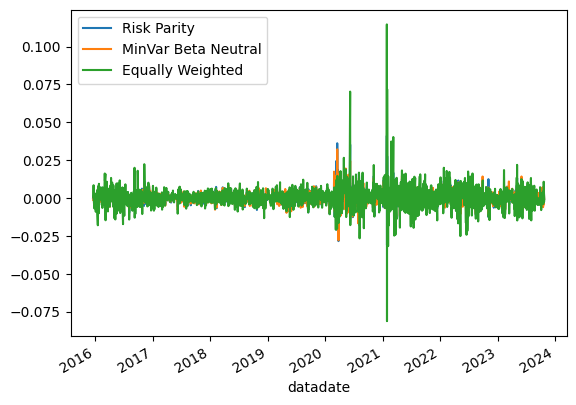

In [52]:
portfolio_return.columns = ['Risk Parity', 'MinVar Beta Neutral', 'Equally Weighted']
portfolio_return.plot()
plt.savefig(FIG_DIR / f"{period}_cumulative_portfolio_return.png", bbox_inches="tight", dpi=200)
plt.savefig(FIG_DIR / f"{period}_weights_plot.png", bbox_inches="tight", dpi=200)

In [53]:
#add snp returns for the same period to evaluate beta
combined_df = portfolio_return.merge(df_sp500, how='left', left_index=True, right_index=True).fillna(0)
rpp_beta, _, _, _, _ = stats.linregress(combined_df['daily_sp500_return'], combined_df['Risk Parity'])
rpp_beta

np.float64(-0.07111746948598668)

In [54]:
#print(combined_df)
#df.to_csv('combined_df.csv', index=False)

In [55]:
EW_beta, _, _, _, _ = stats.linregress(combined_df['daily_sp500_return'], combined_df['Equally Weighted'])
EW_beta

np.float64(0.0464564284155992)

In [56]:
BN_beta, _, _, _, _ = stats.linregress(combined_df['daily_sp500_return'], combined_df['MinVar Beta Neutral'])
BN_beta

np.float64(-0.023027289612434117)

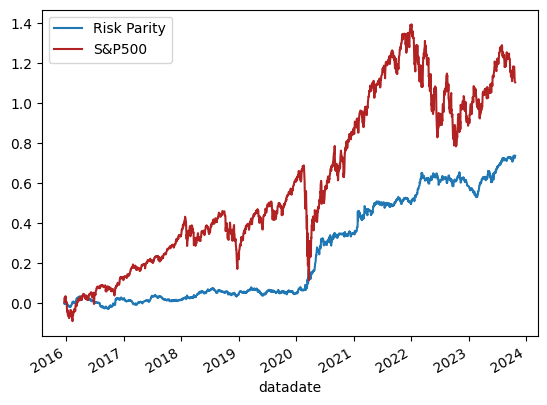

In [57]:
#plot cumulative return
cumulative_snp_return = (combined_df+1).cumprod() -1
cumulative_snp_return.columns = ['Risk Parity', 'MinVar Beta Neutral', 'Equally Weighted', 'S&P500']
cumulative_snp_return['Risk Parity'].plot(label='Risk Parity')
#cumulative_snp_return['MinVar Beta Neutral'].plot(label='MinVar Beta Neutral')
# cumulative_snp_return['Equally Weighted'].plot(label='Equally Weighted')
cumulative_snp_return['S&P500'].plot(color='firebrick', label='S&P500')
plt.legend()

plt.savefig(FIG_DIR / f"{period}_cumulative_portfolio_return.png", bbox_inches="tight", dpi=200)
plt.savefig(FIG_DIR / f"{period}_weights_plot.png", bbox_inches="tight", dpi=200)

In [58]:
#sharpe ratio of each portfolio/snp
combined_df.mean()/combined_df.std()*np.sqrt(252)

Risk Parity            1.098101
MinVar Beta Neutral    0.932381
Equally Weighted       1.066428
daily_sp500_return      0.59819
dtype: Float64

In [45]:
def max_drawdown(ret_df):
    cum_ret = (ret_df+1).cumprod() -1
    wealth = 100 * (1+ cum_ret)
    prev_peak = wealth.cummax()
    mdd = (wealth - prev_peak)/prev_peak
    return mdd.min()
    
print('Maximum Drawdown')
max_drawdown(combined_df)

Maximum Drawdown


Risk Parity           -0.022467
MinVar Beta Neutral   -0.016234
Equally Weighted      -0.018711
daily_sp500_return    -0.036535
dtype: Float64

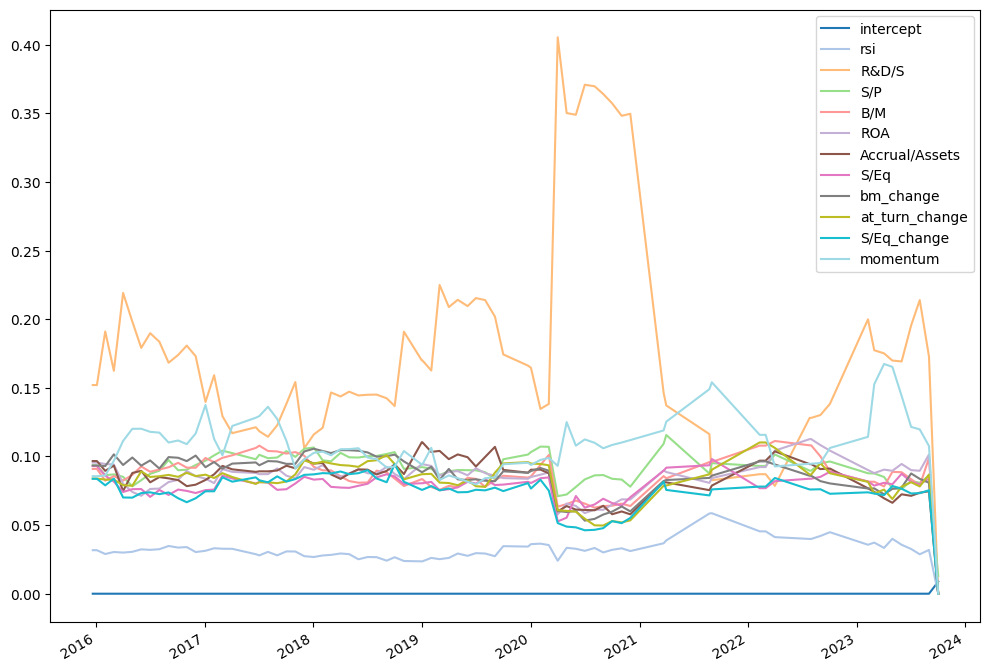

In [46]:
feature_weights.plot(figsize=(12, 9), colormap = 'tab20')
plt.savefig(FIG_DIR / f"{period}_cumulative_portfolio_return.png", bbox_inches="tight", dpi=200)
plt.savefig(FIG_DIR / f"{period}_weights_plot.png", bbox_inches="tight", dpi=200)